In [2]:
# Install the mysql-connector-python package
#!pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#import pandas as pd
#import mysql.connector
#import os

# List of CSV files and their corresponding table names
#csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv','order_items'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
#]

# Connect to the MySQL database
#conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='890',
    database='ecommerce'
#)
#cursor = conn.cursor()

# Folder containing the CSV files
#folder_path = 'E:\\python projects\\e_commerce'

#def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

#for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",
                          username="root",
                          password="ABACUS327bc2",
                          database="ecommerce")
cur=db.cursor()



list all  unique cities where customers are located. 


In [36]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


Count the number of orders placed in 2017.

In [37]:
query="""SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
data

[(90202,)]

In [38]:
"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 90202)

Find the total sales per category. 

In [39]:
query="""SELECT upper(products.product_category) category, round(sum(payments.payment_value),2) 
FROM products join order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id
group by category """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


Calculate the % of orders that were paid in installements. 

In [40]:
query="""SELECT sum(case when payment_installments>=1 then 1 else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data
"the % of orders that were paid in installments is", data[0][0]

('the % of orders that were paid in installments is', Decimal('99.9981'))

count the number of customers from each state.


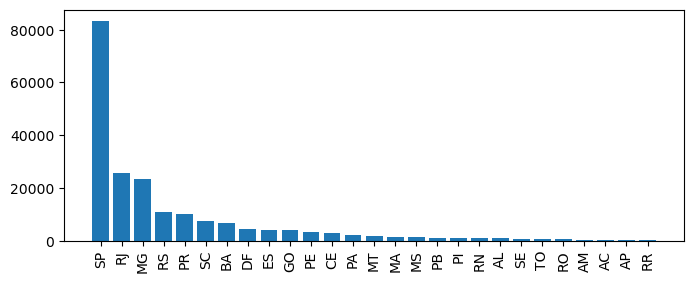

In [41]:
query="""SELECT customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
data

"the the number of customers from each state.", data[0][0]
df=pd.DataFrame(data, columns=["state","customer_count"])
df=df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation=90)
plt.show()

Calculate the number of order per month in year 2018.

In [42]:
query="""SELECT monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)
group by months"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["Months", "order_count"])


In [43]:
df=pd.DataFrame(data, columns=["Months", "order_count"])
df

,Months,order_count
0,October,9918
1,July,20636
2,August,21686
3,November,15088
4,February,17016
5,April,18686
6,May,21146
7,January,16138
8,June,18824
9,March,19786


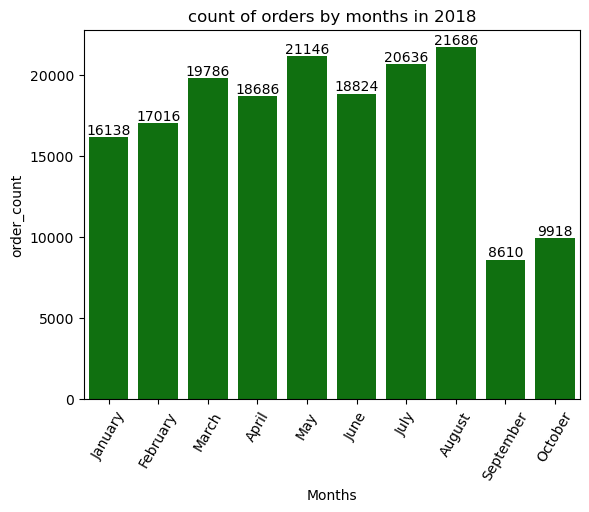

In [44]:
o=["January", "February", "March","April","May","June","July", "August","September","October"]
ax=sns.barplot(x=df["Months"],y=df["order_count"], data=df, order=o, color="green")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=60)
plt.title("count of orders by months in 2018")
plt.show()

Find the average numbers of products per order, grouped by customer city

In [45]:
query="""with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id)as oc
from orders join order_items on orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) avg_order
from customers join count_per_order on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by avg_order desc"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["customer_city", "avg_products_per_order"])

df.head(10)

,customer_city,avg_products_per_order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


Calculate the % of total revenue contributed by each product category

In [46]:
query="""SELECT upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
FROM products join order_items on products.product_id=order_items.product_id
join payments on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["category", "percentage_sales"])

df.head(10)

,category,percentage_sales
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


 Identify the correlation between product price and the number of times a product has been purchased

In [47]:
query="""select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items on 
products.product_id=order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["category", "order_count", "price"])

df.head(10)

,category,order_count,price
0,HEALTH BEAUTY,19340,130.16
1,sport leisure,17282,114.34
2,Cool Stuff,7592,167.36
3,computer accessories,15654,116.51
4,Watches present,11982,201.14
5,housewares,13928,90.79
6,electronics,5534,57.91
7,None,3206,112.00
8,toys,8234,117.55
9,bed table bath,22230,93.30


In [48]:
import numpy as np
arr1=df["order_count"]
arr2=df["price"]
np.corrcoef([arr1, arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

there is neutral relationship, there is no impact on order based on price.

Calculate the total revenue generated by each seller, and ranked by revenue

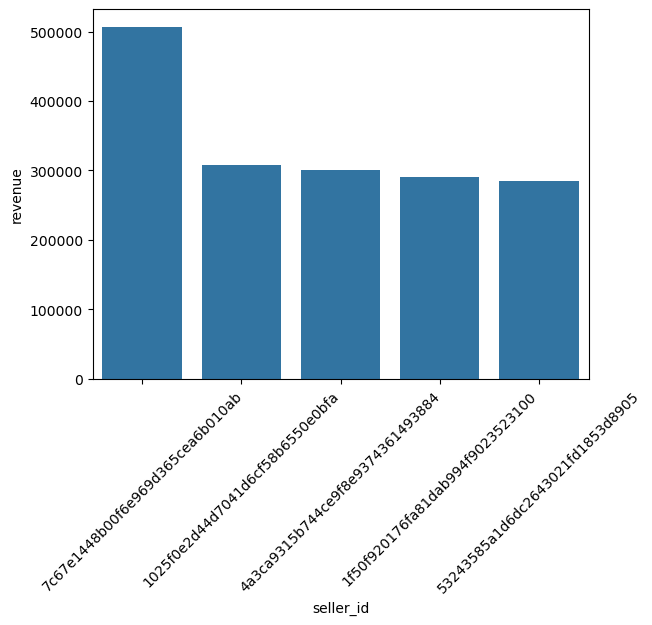

In [49]:
query="""select*, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["seller_id", "revenue", "ranks"])
df=df.head()
sns.barplot(x="seller_id", y="revenue", data=df)
plt.xticks(rotation=45)
plt.show()

Calculate the Moving average of order values for each customers over their order history.

In [50]:
query="""select customer_id, order_purchase_timestamp, payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders on payments.order_id=orders.order_id) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


calculate the cumulative sales per month for each year.

In [51]:
query=""" select years, months, payment, sum(payment)
over (order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,  
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments on orders.order_id=payments.order_id
group by years, months order by years, months) as a;

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["years", "months", "payment", "cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


Calculate the year over year groth rate of total sales.

In [52]:
query="""with a as (select year(orders.order_purchase_timestamp) as years,  
round(sum(payments.payment_value),2) as payment
from orders join payments on orders.order_id=payments.order_id
group by years order by years)
select years, ((payment-lag(payment, 1) over (order by years))/
lag(payment, 1) over (order by years))*100 from a

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["years", "y_o_y5groth"])
df

,years,y_o_y5groth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


Calculate the retention rate of customer, defined as the % of customers who make anaother
purchase within 6 months of their first purchase.

In [53]:
query = """ 
WITH a AS (
    SELECT customers.customer_id,
    MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id  -- Fixed typo: custoemres -> customers
)
SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp)
FROM a JOIN orders ON orders.customer_id = a.customer_id
    AND orders.order_purchase_timestamp > first_order 
    AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 18 MONTH)
GROUP BY a.customer_id;  -- Removed extra closing parenthesis
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

""


Identify top 3 customers who spent the most money in each year.

In [56]:
query="""select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, 
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc ) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp), 
orders.customer_id) as a
where d_rank <=3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","id","payment","rank"])
df

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,2847.100098,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,2801.479980,2
2,2016,4a06381959b6670756de02e07b83815f,2455.560059,3
3,2017,1617b1357756262bfa56ab541c47bc16,27328.160156,1
4,2017,c6e2731c5b391845f6800c97401a43a9,13858.620117,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,13453.320312,3
6,2018,ec5b2ba62e574342386871631fafd3fc,14549.759766,1
7,2018,f48d464a0baaea338cb25f816991ab1f,13844.419922,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,9618.879883,3


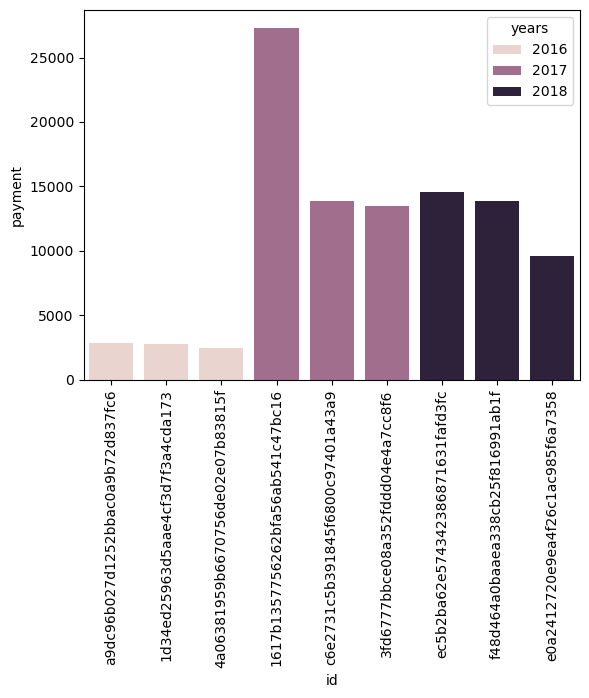

In [57]:
sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()

SyntaxError: invalid syntax (2623065639.py, line 1)